# **EXECUTION SCRIPT**

In [1]:
# !pip install -q -U torch torchvision torchaudio transformers datasets peft bitsandbytes accelerate

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Vee

/content/drive/MyDrive/Colab Notebooks/Vee


In [3]:
# 0. Setup
import matplotlib.pyplot as plt
from finetune_hub import ModelConfig, VLMEngine, DataProcessor, TrainerWrapper, InferenceEngine
from huggingface_hub import login
from google.colab import userdata

In [4]:
# Auto-login
try:
    login(token=userdata.get('HF_TOKEN'))
    print("Login successful!")
except:
    print("Manual login required if HF_TOKEN is not set.")

Login successful!


In [5]:
# 1. Configure (This is the ONLY place you can change settings)
config = ModelConfig()
config.dataset_id = "deepcopy/MathWriting-human"
config.prompt_text = "Convert this handwritten math to LaTeX."
config.batch_size = 4

In [6]:
# 2. Init Engine
engine = VLMEngine(config)
engine.load_model()
model = engine.apply_adapter()

Loading Base Model: google/paligemma-3b-pt-224...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



--- Trainable Parameters ---
trainable params: 22,597,632 || all params: 2,946,064,112 || trainable%: 0.7670


In [7]:
# 3. Load Data
data_proc = DataProcessor(engine.processor, config)
# Use 1000 samples
train_dataset = data_proc.load_data(limit=1000)

Loading dataset: deepcopy/MathWriting-human...


In [8]:
# 4. Train
trainer = TrainerWrapper(
    model=model,
    processor=engine.processor,
    train_dataset=train_dataset,
    cfg=config,
    data_collator=data_proc.collate_fn
)
hf_trainer = trainer.train()

Starting Training...


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Step,Training Loss
5,2.615800
10,2.018100
15,1.511400
20,1.072000
25,1.031200
30,0.827300
35,0.888000
40,0.942800
45,0.801200
50,0.811200


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Saving Trainer State to ./math_vlm_adapter...
Saving Adapter to ./math_vlm_adapter...


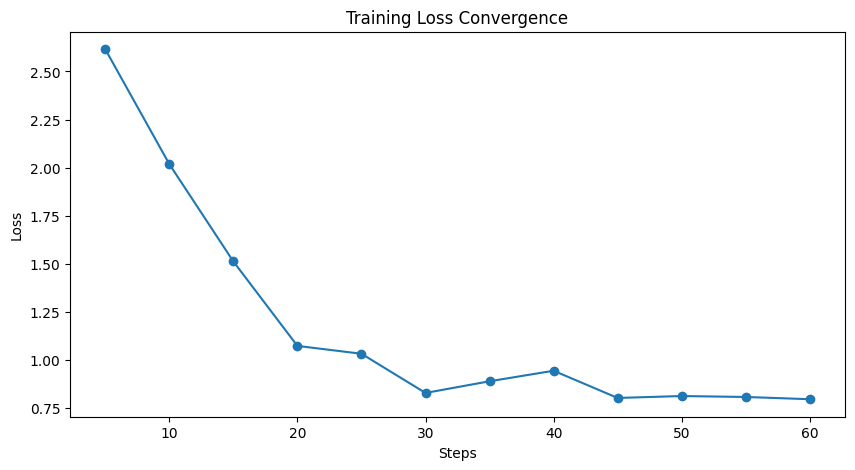

In [9]:
# 5. Visualize Loss
history = hf_trainer.state.log_history
steps = [x["step"] for x in history if "loss" in x]
losses = [x["loss"] for x in history if "loss" in x]

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss Convergence")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [10]:
# 6. Batch Inference & Reporting
import pandas as pd
import os

num_samples_to_test = 5

print(f"\n--- Running Inference on {num_samples_to_test} Samples ---")

# Initialize Inference Engine
inference = InferenceEngine(config.model_id, config.output_dir)

# Create a folder to keep things organized
results_dir = "inference_results"
os.makedirs(results_dir, exist_ok=True)

# List to store results for the summary report
results_data = []

# Loop through the dataset
for i in range(num_samples_to_test):
    # 1. Get Data
    sample = train_dataset[i]
    image = sample["image"]
    ground_truth = sample["latex"]

    # 2. Define Filenames
    image_filename = os.path.join(results_dir, f"sample_{i}.png")
    tex_filename = os.path.join(results_dir, f"output_{i}.tex")

    # 3. Save Image for verification
    image.save(image_filename)

    # 4. Run Inference
    # Note: We pass the image path because our engine expects a path
    generated_latex = inference.generate(image_filename, config.prompt_text, output_file=tex_filename)

    # 5. Print Status
    print(f"[{i+1}/{num_samples_to_test}] Generated: {tex_filename}")

    # 6. Add to data list for summary
    results_data.append({
        "Sample ID": i,
        "Image Path": image_filename,
        "Ground Truth": ground_truth,
        "Predicted LaTeX": generated_latex
    })

# --- Save Summary Report ---
df = pd.DataFrame(results_data)
csv_path = os.path.join(results_dir, "summary_report.csv")
df.to_csv(csv_path, index=False)

print(f"\nDone! Check the '{results_dir}' folder.")
print(f"Summary Report saved to: {csv_path}")

print("\n--- Preview of Results ---")
print(df[["Sample ID", "Predicted LaTeX", "Ground Truth"]].head())


--- Running Inference on 5 Samples ---


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


[1/5] Generated: inference_results/output_0.tex


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


[2/5] Generated: inference_results/output_1.tex


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


[3/5] Generated: inference_results/output_2.tex


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


[4/5] Generated: inference_results/output_3.tex
[5/5] Generated: inference_results/output_4.tex

Done! Check the 'inference_results' folder.
Summary Report saved to: inference_results/summary_report.csv

--- Preview of Results ---
   Sample ID                Predicted LaTeX  \
0          0                     V(\pi^{3})   
1          1                       GL(V)xSn   
2          2          f:X\rightarrow Mr_{r}   
3          3          \{g_{1},g_{2},g_{3}\}   
4          4  \frac{418^{163}}{(1974^{10})}   

                         Ground Truth  
0                    V(\tilde{\beta})  
1                   GL(V)\times S_{n}  
2        \tilde{f}:X\rightarrow M_{f}  
3               \{g_{1},g_{2},g_{3}\}  
4  \frac{418^{163}}{(197^{4}\cdot10)}  


In [ ]:
import matplotlib.pyplot as plt
from finetune_hub import ModelConfig, VLMEngine, DataProcessor, TrainerWrapper, InferenceEngine

In [ ]:
from huggingface_hub import login
from google.colab import userdata

# This automatically pulls the key from the sidebar
try:
    login(token=userdata.get('HF_TOKEN'))
    print("✅ Auto-login successful!")
except Exception as e:
    print("❌ Auto-login failed. Please verify your 'HF_TOKEN' secret.")

✅ Auto-login successful!


In [ ]:
# 1. Initialize Configuration
config = ModelConfig()

# 2. Load Model & Engine
engine = VLMEngine(config)
engine.load_model()
model = engine.apply_adapter()

# 3. Prepare Data
data_proc = DataProcessor(engine.processor, config)
train_dataset = data_proc.load_math_data(limit=1000)

# 4. Train
trainer = TrainerWrapper(
    model=model,
    processor=engine.processor,
    train_dataset=train_dataset,
    cfg=config,
    data_collator=data_proc.collate_fn
)
hf_trainer = trainer.train()

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

trainable params: 22,597,632 || all params: 2,946,064,112 || trainable%: 0.7670


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003-ab0ae6b9fa4a3f(…):   0%|          | 0.00/373M [00:00<?, ?B/s]

data/train-00001-of-00003-589d2b65116e09(…):   0%|          | 0.00/374M [00:00<?, ?B/s]

data/train-00002-of-00003-42472859069c07(…):   0%|          | 0.00/373M [00:00<?, ?B/s]

data/test-00000-of-00001-694f317d8b63419(…):   0%|          | 0.00/44.9M [00:00<?, ?B/s]

data/val-00000-of-00001-184984e66f80ed7a(…):   0%|          | 0.00/81.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/229864 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7644 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/15674 [00:00<?, ? examples/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Step,Training Loss
1,2.822700
2,2.724000
3,2.489300
4,1.994800
5,1.695000
6,1.872000
7,1.461200
8,1.582800
9,1.551800
10,1.466300


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

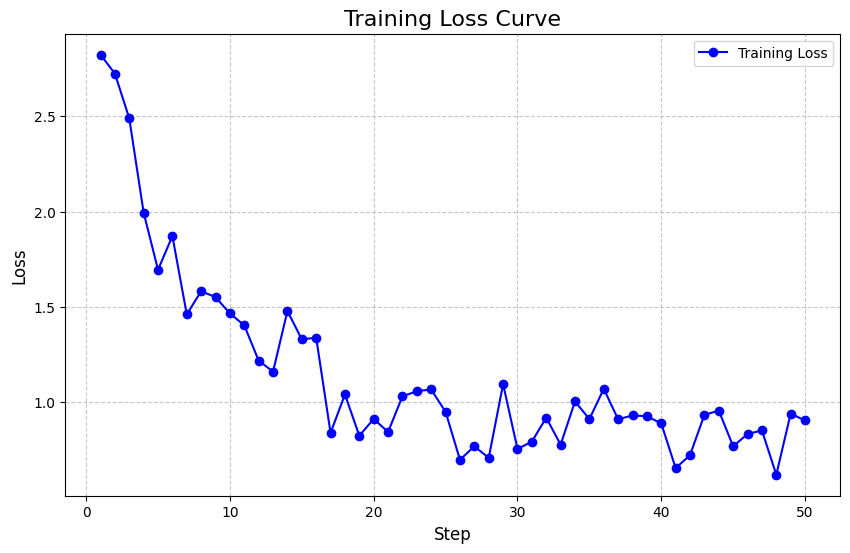

In [ ]:
history = hf_trainer.state.log_history

steps = []
losses = []

for entry in history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label="Training Loss", color="blue", marker="o")

plt.title("Training Loss Curve", fontsize=16)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

In [ ]:
print("\n--- Running Inference ---")
# Use one image from dataset as test input
test_image = train_dataset[0]["image"]
test_image.save("test_input.png")

inference = InferenceEngine(config.model_id, config.output_dir)
result = inference.generate("test_input.png")

print(f"Generated LaTeX saved to output.tex: {result}")


--- Running Inference ---


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Generated LaTeX saved to output.tex: V(\pi^{3})
